In [1]:
import obspy
from obspy import read
from obspy.core.trace import Stats
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.stats as stats
from scipy.stats import norm,kurtosis
import math
import numpy as np
import seaborn as sns

# Function Library

- normalize: to normalize the scale of waveform amplitude
- kurtosis_recursive: kurtosis characteristic function by Langet (2014) which uses recursive algorithm
- kutosis_standard: uses basic definition of kurtosis
- sta_lta: STA/LTA computation. the equation is using reference from Vaezi (2015)

In [66]:
def normalize(data):
    return data/(max(abs(max(data)),abs(min(data))))

def kurtosis_recursive(wf,delay):
    dt = 200 #sample rate
    n = int(delay*dt)
    w = n
    c = 1 - (1/w)
    
    tes = []
    mean1, sigma1 = norm.fit(wf[0:n]) # nilai awal
    meanx, sigmax = norm.fit(wf) # dipakai saat sigma < sigma1
    a1 = stats.kurtosis(wf[0:n]) # nilai awal
    a1 = 0
    for i in range(n,len(wf)):
        i = int(i)
        data = wf[(i-n):i]
        mean = c*mean1 + (1-c) * wf[i]
        sigma = c*sigma1 + (1-c) * (wf[i]-mean)**2
        
        if (sigma>sigmax) and (sigma!=0):
            a = c*a1 + (1-c) * ((wf[i]-mean)**4)/(sigma**2)
        else:
            a = c*a1 + (1-c) * ((wf[i]-mean)**4)/(sigmax**2)
        
        if a>0:
            tes.append(a)
        else:
            tes.append(0)
    #     kurt.append(kurtosis(data,mean,sigma))
        
        mean1 = mean
        sigma1 = sigma
        a1 = a

    awal = np.full(n,0,dtype=int)
    kurt = np.insert(tes,awal,tes[0], axis=0)
        
    return kurt

def kurtosis_standard(wf,delay):
    n = int(delay*200)
    tes = []

    for i in range(n,len(wf)):
        i = int(i)
        data = wf[(i-n):i]
        mean, sigma = stats.norm.fit(data)
        a = stats.kurtosis(data)
        if a>0:
            tes.append(a)
        else:
            tes.append(0)
    #     kurt.append(kurtosis(data,mean,sigma))

    awal = np.full(n,tes[0],dtype=float)
    kurt = np.insert(tes,awal,tes[0], axis=0)
    
    return kurt

def stalta(wf,ns=50,nl=300):
    y = abs(wf)
    sta,lta = [],[]
    for i in range(nl,len(y)-ns):
        s = 1 / ns * sum([y[j] for j in range(i,i+ns)])
        l = 1 / nl * sum([y[j] for j in range(i-nl,i)])
        sta.append(s),lta.append(l)

    awal = np.full(nl,sta[0],dtype=int)
    sta = np.insert(sta,awal,0,axis=0)
    awal = np.full(nl,lta[0],dtype=int)
    lta = np.insert(lta,awal,0,axis=0)

    stalta = [sta[i]/lta[i] for i in range(len(sta))]
    return stalta,sta,lta



# Data Reading

In [9]:
stream = read("event\\700\\*.SAC")
stream2 = read("event\\231\\*.SAC")

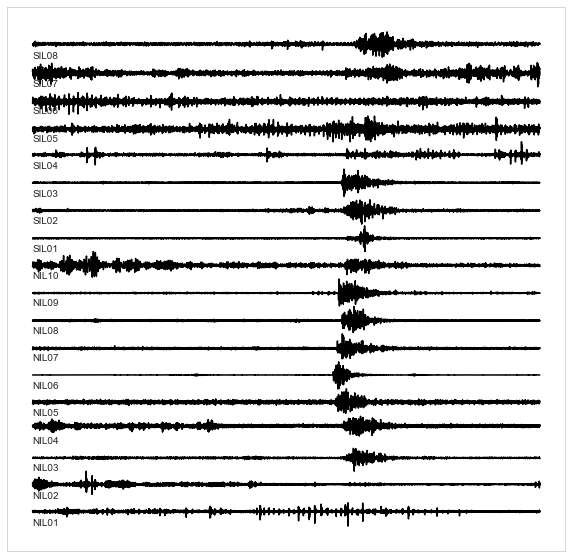

In [13]:
# plotting z component of all station

a = stream2.select(component='z')

sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
ax = plt.gca()
for i in range(len(a)):
    plt.plot(normalize(a[i].data)+2*i,'k-')
    ax.text(0.05,(i-0.5)*2,str(a[i].stats.station))

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

NIL06


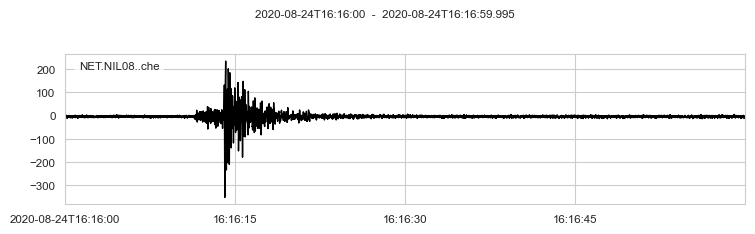

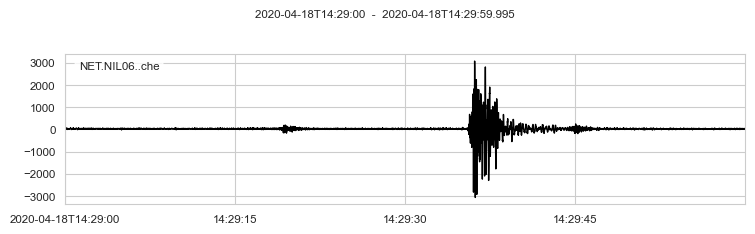

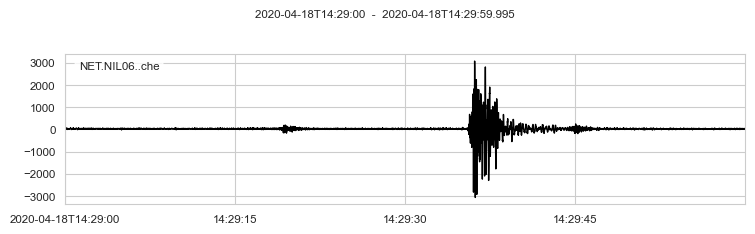

In [14]:
# plotting one station

tr = stream.select(station="NIL08")[0]
tr2 = stream2.select(station="NIL06")[0]
tr2 = tr2.detrend()
print(tr2.stats.station)
tr.plot()
tr2.plot()

# Histogram Plotting

to check how much the difference between gaussian distribution and the tip of the histogram. in the window where event onset is present, the tip of the histogram will be far above the tip of gaussian distribution

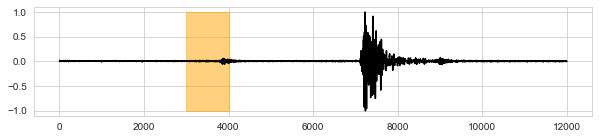

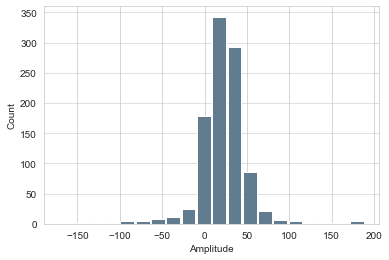

In [42]:
wf = tr.data[0:len(tr.data)]
wf2 = tr2.data[0:len(tr2.data)]

# define the variable
data = wf2
startpoint = 3000
width = 1000

fig = plt.figure(figsize=(10,2))
ax = fig.add_subplot(1,1,1)
ax.plot(normalize(data),"k-")
ax.add_patch(
    patches.Rectangle(
        xy=(startpoint,-1),
        width=width,
        height=2,
        linewidth=1,
        color='orange',
        fill=True,
        alpha=0.5
    )
)
plt.show()

counts,bins,bar=plt.hist(data[startpoint:startpoint+width],bins = 20, rwidth=0.9, color='#607c8e')
plt.xlabel('Amplitude')
plt.ylabel('Count')
plt.grid(axis='y',alpha=0.75)
plt.show()

Text(0.5, 0, 'Data')

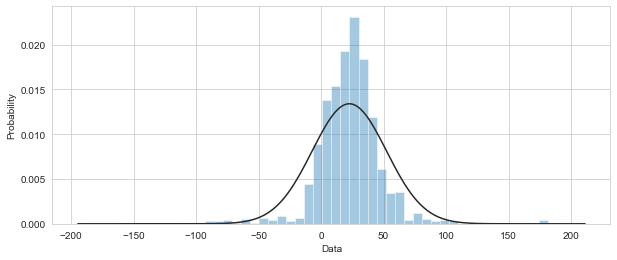

In [36]:
# gaussian fitting

import seaborn as sns
from scipy.stats import norm
fig=plt.figure(figsize=(10,4))
sns.set_style("whitegrid")
ax = sns.distplot(data[startpoint:startpoint+width], fit=norm, kde=False)
plt.ylabel('Probability')
plt.xlabel('Data')

# Kurtosis Plotting

## Standard Kurtosis

In [40]:
kurt4 = kurtosis_standard(wf2,4)
kurt1 = kurtosis_standard(wf2,1)
kurt2 = kurtosis_standard(wf2,2)
kurt05 = kurtosis_standard(wf2,0.5)

<ipython-input-39-8a6c24fec667>:57: DeprecationWarning: using a non-integer array as obj in insert will result in an error in the future
  kurt = np.insert(tes,awal,tes[0], axis=0)


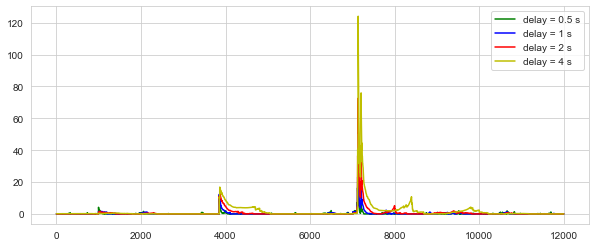

In [43]:
plt.figure(figsize=(10,4))

plt.plot(kurt05,'g-',label='delay = 0.5 s')
plt.plot(kurt1,'b-',label='delay = 1 s')
plt.plot(kurt2,"r-",label='delay = 2 s')
plt.plot(kurt4,'y-',label='delay = 4 s')
plt.legend()
plt.show()

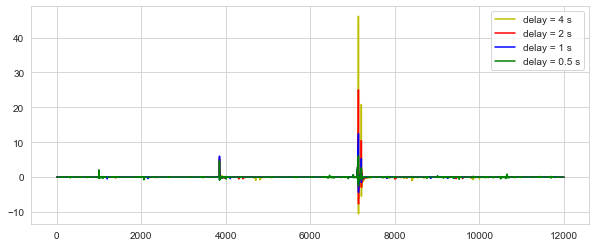

In [44]:
# gradient of standard kurtosis

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(np.gradient(kurt4),"y-",label='delay = 4 s')
ax.plot(np.gradient(kurt2),"r-",label='delay = 2 s')
ax.plot(np.gradient(kurt1),"b-",label='delay = 1 s')
ax.plot(np.gradient(kurt05),"g-",label='delay = 0.5 s')
# plt.xlim(500,1500)
# plt.ylim(0,4)
plt.legend()
plt.show()

## Recursive Kurtosis

In [50]:
kurt2_rec = kurtosis_recursive(wf2,2)
kurt1_rec = kurtosis_recursive(wf2,1)
kurt4_rec = kurtosis_recursive(wf2,4)
kurt05_rec = kurtosis_recursive(wf2,0.5)

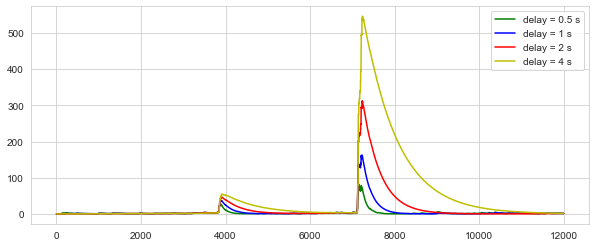

In [51]:
plt.figure(figsize=(10,4))

plt.plot(kurt05_rec,'g',label='delay = 0.5 s')
plt.plot(kurt1_rec,'b-',label='delay = 1 s')
plt.plot(kurt2_rec,"r-",label='delay = 2 s')
plt.plot(kurt4_rec,'y-',label='delay = 4 s')
plt.legend()
# plt.xlim(750,1100)
plt.show()

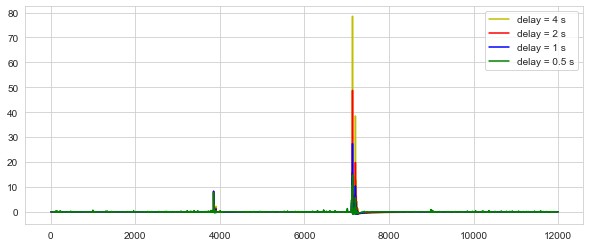

In [52]:
# Gradient

plt.figure(figsize=(10,4))
plt.plot(np.gradient(kurt4_rec),'y-',label='delay = 4 s')
plt.plot(np.gradient(kurt2_rec),"r-",label='delay = 2 s')
plt.plot(np.gradient(kurt1_rec),'b-',label='delay = 1 s')
plt.plot(np.gradient(kurt05_rec),'g',label='delay = 0.5 s')
plt.legend()
# plt.xlim(1250,1400)
plt.show()

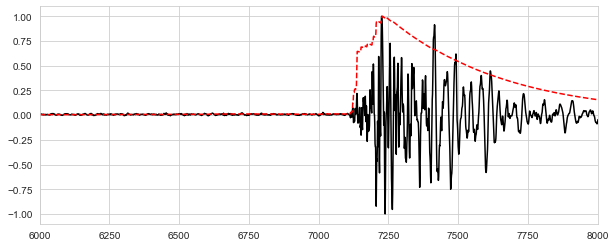

In [60]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.plot(normalize(wf2),"k-")
ax.plot(normalize(kurt2_rec),"r--", label = 'Kurtosis Rekursif')
#ax.plot(kurt2*4,"b--", label = 'Kurtosis Standar')
plt.xlim(6000,8000)
#plt.legend()
plt.show()

# STA/LTA

here i tried to compare the result of STA/LTA equation using equation in Vaezi (2015) and Obspy library

<ipython-input-66-67c1765dc478>:74: RuntimeWarning: invalid value encountered in double_scalars
  stalta = [sta[i]/lta[i] for i in range(len(sta))]
<ipython-input-66-67c1765dc478>:74: RuntimeWarning: divide by zero encountered in double_scalars
  stalta = [sta[i]/lta[i] for i in range(len(sta))]


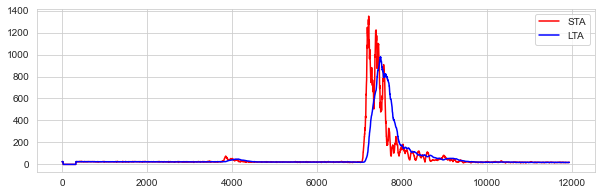

In [69]:
sta_lta, sta, lta = stalta(wf2)

plt.figure(figsize=(10,3))
# plt.plot(sta_lta,label='STA/LTA',color='black')
plt.plot(sta,label='STA',color='red')
plt.plot(lta,label='LTA',color='blue')
plt.legend()
plt.show()

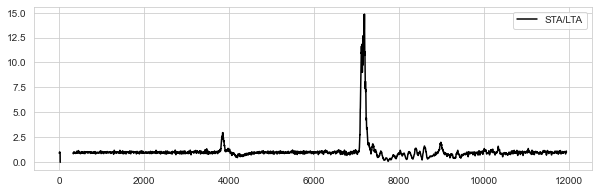

In [68]:
plt.figure(figsize=(10,3))
plt.plot(sta_lta,label='STA/LTA',color='black')
plt.legend()
plt.show()

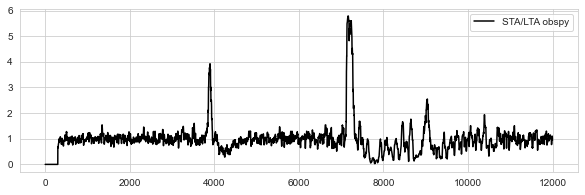

In [71]:
# classic sta/lta from obspy

a = classic_sta_lta(tr2,50,300)
plt.figure(figsize=(10,3))
plt.plot(a,label='STA/LTA obspy',color='black')
plt.legend()
plt.show()

# All Station

## Recursive Kurtosis

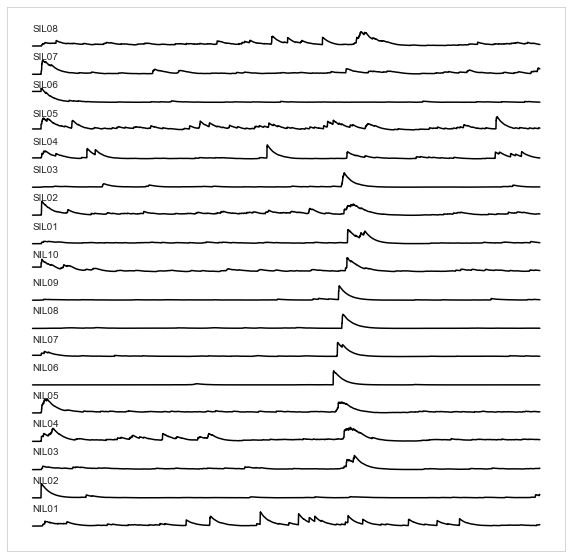

In [47]:
a = stream2.select(component='z')
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
ax = plt.gca()
for i in range(len(a)):
    rec = kurtosis_recursive(a[i].data,1)
    plt.plot(normalize(rec)+2*i,'k-')
    ax.text(0.05,(i+0.5)*2,str(a[i].stats.station))

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

## Recursive Kurtosis Gradient

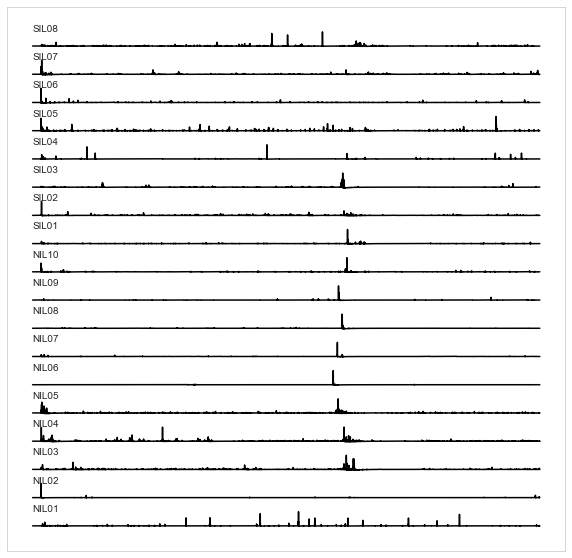

In [49]:
a = stream2.select(component='z')
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
ax = plt.gca()
for i in range(len(a)):
    rec = kurtosis_recursive(a[i].data,1)
    plt.plot(normalize(np.gradient(rec))+2*i,'k-')
    ax.text(0.05,(i+0.5)*2,str(a[i].stats.station))

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

# STA/LTA

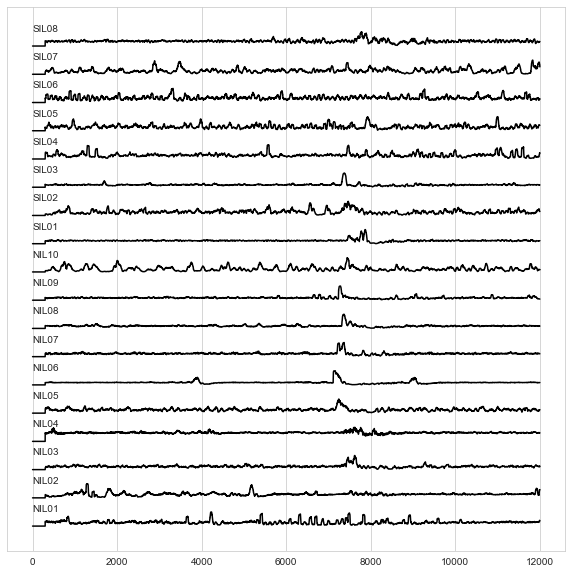

In [46]:
from obspy.signal.trigger import classic_sta_lta
from obspy.signal.trigger import recursive_sta_lta

a = stream2.select(component='z')
sns.set_style("whitegrid")
plt.figure(figsize=(10,10))
ax = plt.gca()
for i in range(len(a)):
    tes = classic_sta_lta(a[i].data,50,300)
    plt.plot(normalize(tes)+2*i,'k-')
    ax.text(0.05,(i+0.5)*2,str(a[i].stats.station))

# ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()